In [1]:
import numpy as np
import pandas as pd
import os
import natsort as ns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib.widgets import Slider
from sklearn.neighbors import NearestNeighbors


In [2]:
path = '/Users/georgienahass/Desktop/alkureishiLab/thermal_camera/thermalData_expeirment_1'

file_list = []

for root, dirs,files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            path =(os.path.join(root, file))
            file_list.append(path)

file_list = ns.natsorted(file_list)

In [3]:
dfs = []
threshold = 25
interestingDfs = []
x_axis = []

for idx, file in enumerate(file_list):
    try:
        df = pd.read_csv(file, skiprows = 3, header=None) 
        fake_column_names = [f"col{i}" for i in range(0, len(df.columns))]

        if (df>threshold).any().any():
            interestingDfs.append(df)
        
        max_val = df.max().max()
        mean_val = df.mean().mean()

        x_axis.append(idx+1)
        # df = df.rename(columns={'Height': 'Unnamed: 0', '240': 'Unnamed: 1'})
        dfs.append(df)

    except pd.errors.EmptyDataError:
        pass

In [4]:
threshold_indices = []
for df in interestingDfs:
    idx = np.where(df.values > threshold)
    pairs = list(zip(idx[0], idx[1]))
    threshold_indices.append(pairs)
flat_list = [item for sublist in threshold_indices for item in sublist]
unique_indices = list(set(flat_list))

zeroedDFs = []
for df in dfs:
    mask = pd.DataFrame(False, index=df.index, columns=df.columns)
    for i, j in unique_indices:
        mask.iloc[i, j] = True
    df = df.where(mask, np.nan)
    zeroedDFs.append(df)

In [5]:

# for idx, df in enumerate(zeroedDFs):
#     name = '/Users/georgienahass/Desktop/alkureishiLab/thermal_camera/testingData/zeros/' +str(idx)+'.csv'
#     df.to_csv(name)

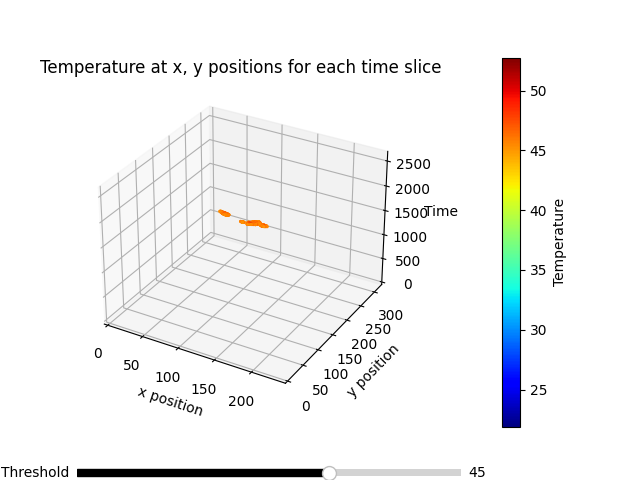

In [10]:

arrays = [data.values for data in zeroedDFs]
matrix = np.stack(arrays[1:])

thresh_init = 45

# create a figure and axis object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

vmin = np.nanmin(matrix)
vmax = np.nanmax(matrix)
matrix[matrix < thresh_init] = np.nan

# create a 3D volume object
def create_vol(thresh_func):
    temp = np.copy(matrix)
    temp[temp < thresh_func] = np.nan
    mask = np.isnan(temp)
    mask = np.logical_not(mask)
    mask = mask.transpose(2, 1, 0)
    temp = temp.transpose(2, 1, 0)
    x, y, z = np.meshgrid(np.arange(temp.shape[1]), np.arange(temp.shape[0]), np.arange(temp.shape[2]))
    return ax.scatter(x[mask], y[mask], z[mask], c=temp[mask], cmap='jet', s=1, alpha=1, vmin=vmin, vmax=vmax)
# c=temp[mask], cmap='jet'

vol = create_vol(thresh_init)

cbar = fig.colorbar(vol, pad=0.2)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.set_ylabel('Temperature')

title = ax.set_title('Temperature at x, y positions for each time slice')
title.set_position((0.5, 1.05))

ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_zlabel('Time')
ax.set_zlim(0, matrix.shape[0])
ax.set_xlim(0, matrix.shape[1])
ax.set_ylim(0, matrix.shape[2])

axthresh = plt.axes([0.12, 0.00, 0.6, 0.03], facecolor='lightgoldenrodyellow')
thresh_slider = Slider(axthresh, 'Threshold', 20, 58, valinit=thresh_init, color = 'black')

# Define the update function
def update(val):
    thresh = thresh_slider.val
    global vol
    vol.remove()
    vol = create_vol(thresh)
    fig.canvas.draw_idle()

# # Link the slider to the update function
thresh_slider.on_changed(update)

plt.show()
